# 2D Random Walk
## Packages

In [1]:
include("RandomWalk.jl")
using Plots, LaTeXStrings, Statistics, DelimitedFiles
import PyPlot as plt

## Configurations

In [2]:
figpath = "../fig/"
rcParams = plt.PyDict(plt.matplotlib["rcParams"])
rcParams["text.usetex"] = true

true

## Heat Map

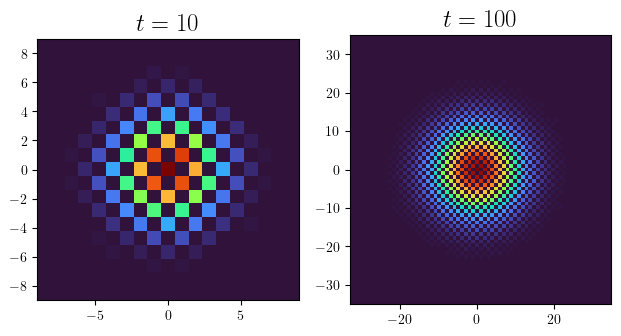

In [10]:
fig, axs = plt.subplots(1, 2)
plt.tight_layout()

times = (10, 100)
for i in 1:2
    ax = axs[i]
    x, y, grid = RandomWalk.randomwalk2d(times[i]; walks = 10000 * times[i])

    ax.set_title(L"t=%$(times[i])", fontsize=18)
    ax.imshow(grid, extent=(x[1], x[end], y[1], y[end]), cmap="turbo", interpolation="nearest")
end

display(fig)
plt.savefig(figpath * "randomwalk-2d-small.pdf", bbox_inches="tight")

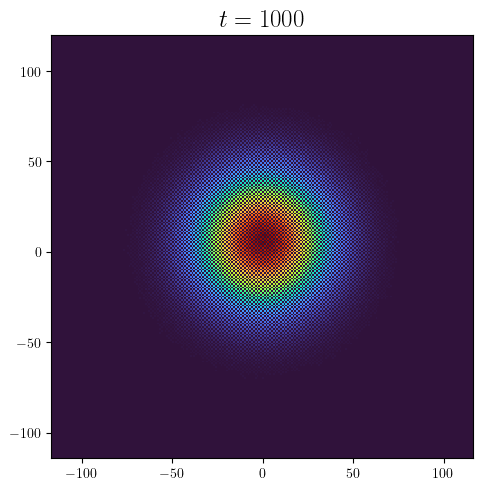

In [15]:
fig, ax = plt.subplots()
plt.tight_layout()

x, y, grid = RandomWalk.randomwalk2d(1000; walks=10^7)

ax.set_title(L"t=1000", fontsize=18)
ax.imshow(grid, extent=(x[1], x[end], y[1], y[end]), cmap="turbo", interpolation="nearest")

display(fig)
plt.savefig(figpath * "randomwalk-2d-large.pdf", bbox_inches="tight")

## Radius of Gyration

In [12]:
function meansqdist(grid)
    mass = sum(grid)
    height, width = size(grid)
    ycenter, xcenter = height ÷ 2, width ÷ 2

    ∑mr² = 0
    for i in 1:height
        for j in 1:width
            ∑mr² += grid[i, j] * ((i - ycenter)^2 + (j - xcenter)^2)
        end
    end

    return ∑mr² / mass
end

meansqdist (generic function with 1 method)

In [21]:
samples = 20
times = [round(Integer, ℯ^t) for t in range(log(50), log(1000), length=samples)]

20-element Vector{Int64}:
   50
   59
   69
   80
   94
  110
  129
  151
  177
  207
  242
  283
  332
  388
  455
  532
  623
  730
  854
 1000

In [27]:
σ² = Vector{Float64}(undef, samples)
for i in 1:samples
    σ²[i] = meansqdist(RandomWalk.randomwalk2d(times[i]; walks = 5 * 10^5 * times[i])[3])
end

# save data to file
open("randomwalk-2d.txt", "w") do io
    writedlm(io, [times σ²])
end

In [28]:
# load data from file
data = readdlm("randomwalk-2d.txt")
times, σ² = data[:, 1], data[:, 2]
samples = length(times)

20

In [31]:
timelog, σ²log = log.(times), log.(σ²)
exponent, constterm = hcat(timelog, ones(samples)) \ σ²log

errorexp = √(sum(x->x^2, σ²log - exponent * timelog .- coefficient) / (samples - 2)
    / sum(x->x^2, timelog .- mean(timelog)))
errorconst = errorexp * √(sum(x->x^2, timelog) / samples)

coefficient = ℯ^constterm
# Δ(e^x) = ∂(e^x)/∂x Δx = e^x Δx
errorcoeff = ℯ^constterm * errorconst

println(exponent, ' ', errorexp)
println(coefficient, ' ', errorcoeff)

0.9972405434841545 0.004033033021353677
1.0363445619115128 0.022931840230175603


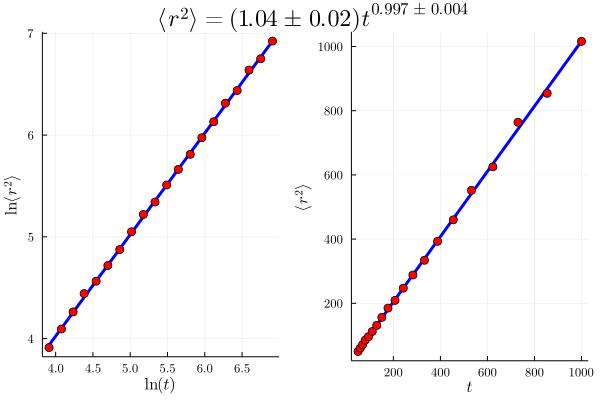

In [38]:
p1 = plot(x -> x * exponent + constterm, timelog, c=:blue, lw=3,
    xlabel=L"\mathrm{ln}(t)", ylabel=L"\mathrm{ln} \langle r^2 \rangle")
scatter!(p1, timelog, σ²log, c=:red, ms=5)

p2 = plot(t -> coefficient * t^exponent, times, c=:blue, lw=3,
    xlabel=L"t", ylabel=L"\langle r^2 \rangle")
scatter!(p2, times, σ², c=:red, ms=5)

p = plot(p1, p2, layout = (1, 2), legend=false, fontfamily="Computer Modern",
    plot_title="\$ \\langle r^2 \\rangle = ($(round(coefficient, digits=2))"
    * "\\pm $(round(errorcoeff, sigdigits=1))) t^{$(round(exponent, digits=3)) \\pm"
    * "$(round(errorexp, sigdigits=1))}\$")

savefig(p, figpath * "randomwalk-2d-msd.pdf")
display(p)